In [1]:
import numpy as np
import matplotlib.pyplot as plt

from landlab import RasterModelGrid
from landlab.plot import imshow_grid

from scipy.ndimage import gaussian_filter

#### Objective
Following Kessler et al. (2008), implement a flux-based shallow ice approximaion.
The governing equation for depth-integrated velocity $\bar{U}$ is:
$$ \bar{U} = \frac{2A}{n + 2}(\rho_i g S)^n H^{n+1}, $$
where $A$ is Glen's flow law coefficient, $n$ is Glen's flow law exponent, $\rho_i$ is ice density, $g$ is gravitational acceleration, $S$ is the ice surface elevation, and $H$ is the ice thickness. The ice thickness then evolves by:
$$ \frac{\partial H}{\partial t} = b_z - \frac{\partial q_x}{\partial x} - \frac{\partial q_y}{\partial y},$$
where $b_z$ is the mass balance, and $q = \bar{U}H$ is the ice flux.

In [2]:
class ShallowIceApproximation:
    
    def __init__(self, grid, initial_bedrock, initial_thickness, mass_balance):
        
        # Set constants, kg/m/s
        self.sec_per_a = 31536000 # appx. seconds per year
        self.rho = 917 # kg m^-3
        self.g = 9.81 # m s^-2
        self.n = 3
        self.A = 6.8e-24 # s^-1 Pa^-3, see Cuffey and Paterson (2010)
        self.flow_coeff = (2 * self.A) / (self.n + 2)
        self.CFL = 0.05 # constant for CFL condition
        
        self.grid = grid
        
        self.stable_time_step = 0.0
        self.time_elapsed = 0.0
    
        # Add all of the field variables
        if 'bedrock_elevation' not in self.grid.at_node:
            self.grid.add_field('bedrock_elevation', initial_bedrock, at = 'node')
            
        if 'ice_thickness' not in self.grid.at_node:
            self.grid.add_field('ice_thickness', initial_thickness, at = 'node')
            
        if 'surface_elevation' not in self.grid.at_node:
            initial_surface = self.grid.at_node['bedrock_elevation'] + self.grid.at_node['ice_thickness']
            self.grid.add_field('surface_elevation', initial_surface, at = 'node')
        
        if 'mass_balance' not in self.grid.at_node:
            self.grid.add_field('mass_balance', mass_balance, at = 'node')
            
        if 'velocity' not in self.grid.at_link:
            self.grid.add_zeros('velocity', at = 'link')
            
        if 'ice_flux' not in self.grid.at_link:
            self.grid.add_zeros('ice_flux', at = 'link')
    
    # Calculate the depth-integrated ice velocity at each node
    def solve_stress_balance(self):
        
        # Map thickness and surface slope to links, using upwind scheme
        self.ice_thickness_at_links = self.grid.map_value_at_max_node_to_link('ice_thickness', 'ice_thickness')
        self.slope = np.abs(self.grid.calc_grad_at_link('surface_elevation'))
        
        # Driving stress = (rho * g * S)^n * H^n+1
        self.driving_stress = (
            (self.rho * self.g * self.slope)**self.n
            * self.ice_thickness_at_links**(self.n + 1)
        )
        
        # Velocity = flow coefficient * driving stress
        self.grid.at_link['velocity'] = self.flow_coeff * self.driving_stress
        
        # Flux = velocity * ice thickness
        self.grid.at_link['ice_flux'] = self.grid.at_link['velocity'] * self.ice_thickness_at_links
        
    def calculate_stable_time_step(self):
         self.stable_time_step = (self.CFL * self.grid.dx) / np.abs(self.grid.at_link['velocity']).max()
       
    # Each time step, update the ice velocity and ice flux, then update the ice thickness by forward Euler    
    def run_one_step(self):
        
        # Update the ice velocity and ice flux
        self.solve_stress_balance()
        
        # Calculate the stable time step
        self.calculate_stable_time_step()
        
        # Calculate the change in thickness
        self.grid.at_node['ice_thickness'] += (self.grid.at_node['mass_balance'] + self.grid.calc_flux_div_at_node('ice_flux')) * self.stable_time_step
        
        self.time_elapsed += self.stable_time_step
        
        # Where the ice thickness has gone below zero, set it to equal zero
        self.grid.at_node['ice_thickness'] = np.where(self.grid.at_node['ice_thickness'] >= 0, self.grid.at_node['ice_thickness'], 0)
        
        # Recalculate the surface elevation
        self.grid.at_node['surface_elevation'] = self.grid.at_node['bedrock_elevation'] + self.grid.at_node['ice_thickness']

### Prototyping
Set up a ~200m-thick chunk of ice on top of a ~1000m bedrock dome. Following Kessler et al. (2008), let the mass balance scale with elevation after 300m. 

In [3]:
mg = RasterModelGrid((100, 100), 1000)
initial_bedrock = 0 * np.exp(-(((mg.node_x - 50000) / 40000)**2 + ((mg.node_y - 50000) / 40000)**2), dtype = np.float64)
initial_thickness = 1000 * np.exp(-(((mg.node_x - 50000) / 40000)**2 + ((mg.node_y - 50000) / 40000)**2), dtype = np.float64)
mass_balance = np.where(initial_bedrock >= 300, initial_bedrock * 0.05 * 3.14e-7, 0)

sia = ShallowIceApproximation(mg, initial_bedrock, initial_thickness, mass_balance)

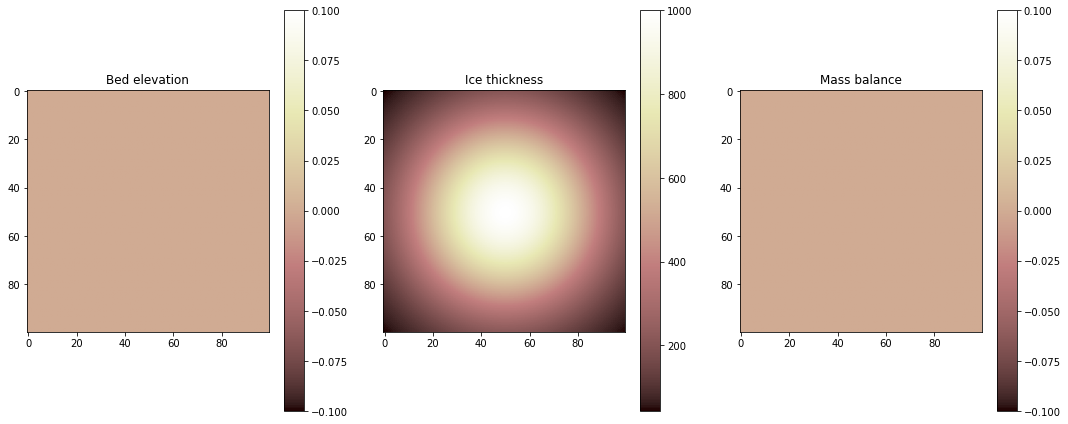

In [4]:
fig, ax = plt.subplots(1, 3, figsize = (15, 6))

im0 = ax[0].imshow(mg.at_node['bedrock_elevation'].reshape((100, 100)), cmap = 'pink')
fig.colorbar(im0, ax = ax[0])
ax[0].set_title('Bed elevation')

im1 = ax[1].imshow(mg.at_node['ice_thickness'].reshape((100, 100)), cmap = 'pink')
fig.colorbar(im1, ax = ax[1])
ax[1].set_title('Ice thickness')

im2 = ax[2].imshow(mg.at_node['mass_balance'].reshape((100, 100)), cmap = 'pink')
fig.colorbar(im2, ax = ax[2])
ax[2].set_title('Mass balance')

plt.tight_layout()
plt.show()

To help visualize the problem, below, this is a 3D plot of the initial surface elevation.

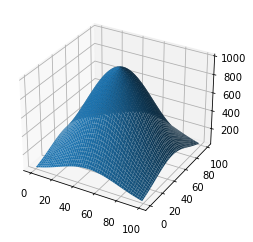

In [5]:
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})

nx = 100
ny = 100
x, y = np.meshgrid(range(nx), range(ny))
z = sia.grid.at_node['surface_elevation'].reshape((nx, ny))

ax.plot_surface(x, y, z)

plt.show()

/home/egp/anaconda3/envs/landlab/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
/home/egp/anaconda3/envs/landlab/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


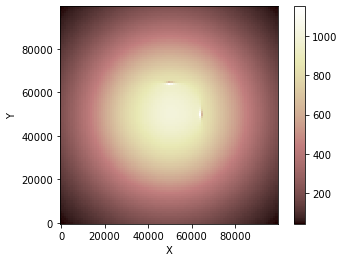

In [6]:
for i in range(10):
    sia.run_one_step()
#     print(sia.stable_time_step / 60 / 60 / 24)
imshow_grid(mg, 'ice_thickness')

In [7]:
print(sia.time_elapsed / 60 / 60 / 24)

355.507900611


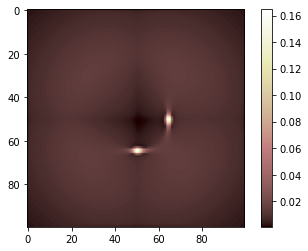

In [8]:
plt.imshow(sia.grid.map_mean_of_links_to_node(sia.slope).reshape(100, 100), cmap = 'pink')
plt.colorbar()
plt.show()

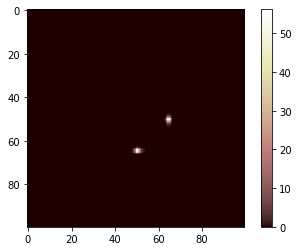

In [9]:
plt.imshow(sia.grid.map_mean_of_links_to_node(sia.grid.at_link['ice_flux']).reshape(100, 100), cmap = 'pink')
plt.colorbar()
plt.show()

In [10]:
print(sia.grid.at_link['velocity'].max() * 3.14e7)

6105098.18222


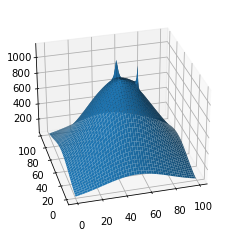

In [11]:
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})

nx = 100
ny = 100
x, y = np.meshgrid(range(nx), range(ny))
z = sia.grid.at_node['surface_elevation'].reshape((nx, ny))

ax.view_init(30, 255)
ax.plot_surface(x, y, z)

plt.show()